# Homework 02 Mini-batch learning

Name: Seres Zsombor, Neptun: Sere Zsombor, e-mail: zsombi9998@gmail.com
This notebook is based of this notebook: https://github.com/BME-SmartLab-Education/vitmav45/blob/master/02/XOR_Numpy_backprop.ipynb The goal of this notebook is to use mini-batches for a forward-backward learning step instead of only one sample. 

<p dir="auto"><a href="https://colab.research.google.com/drive/11AYbRd1MZWsCYkXHz01VLFryZ8Tb2nPP" rel="nofollow" data-turbo-frame="repo-content-turbo-frame"><img src="https://camo.githubusercontent.com/84f0493939e0c4de4e6dbe113251b4bfb5353e57134ffd9fcab6b8714514d4d1/68747470733a2f2f636f6c61622e72657365617263682e676f6f676c652e636f6d2f6173736574732f636f6c61622d62616467652e737667" alt="Open in Colab" data-canonical-src="https://colab.research.google.com/assets/colab-badge.svg" style="max-width: 100%;"></a></p>

## 0. Imports, installs, configs

In [63]:
!pip install numpy tensorboard matplotlib sklearn tensorboardX

In [64]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn
from tensorboardX import SummaryWriter

from typing import List
import math
from datetime import datetime

## 1. The dataset

I will use the same dataset(XOR problem) as seen in the notebbok.

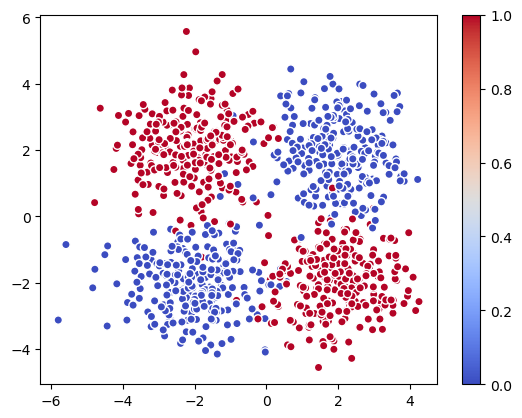

In [65]:
# Creating the dataset
nb_samples=1000
X = np.zeros((nb_samples,2))
Y = np.zeros(nb_samples)
for i in range(0,nb_samples,4):
    noise = np.random.normal(0,1,8)
    X[i], Y[i] = (-2+noise[0],-2+noise[1]), 0
    X[i+1], Y[i+1] = (2+noise[2],-2+noise[3]), 1
    X[i+2], Y[i+2] = (-2+noise[4],2+noise[5]), 1
    X[i+3], Y[i+3] = (2+noise[6],2+noise[7]), 0

# plotting
plt.scatter(X[:,0],X[:,1],c=Y[:], cmap=plt.cm.coolwarm, linewidth=1, edgecolors='w')
plt.colorbar();

## 2. Activation function

I will use sigmoid, as seen in the original notebook.

In [7]:
def activation(x):
    """Function that works as a sigmoid function."""
    return 1.0 / (1.0 + np.exp(-x))

def dactivation(x):
    """Function that works as the derivate of the sigmoid function."""
    return np.exp(-x) / (1 + np.exp(-x))**2

## 3. Creating the neuron network

To make it work with minibatches i will do the following chages:
The propgate_forward function will take a mini-batch of data instead only 1 vector of input. Then it will itarate through the batch elements, than the output will be the the avarage of each batch member's output. No changes will be done in the backward step. This method requires to make batches before startint the training process. To make it work i had to calculate the average of the gradients instead of the error.

In [186]:
class MLP:
    
    def __init__(self, *args):
        """
        Initalizing the neural network using the sizes added in the *args argument.
        """
        # adding random seed
        np.random.seed(123)
        self.shape = args
        n = len(args)
        # Creating layers
        self.layers = []
        # Input layer (+1 because of BIAS)
        self.layers.append(np.ones(self.shape[0]+1))
        # Hidden layers and output layer
        for i in range(1,n):
            self.layers.append(np.ones(self.shape[i]))
        # Creating the weight matrix.
        self.weights = []
        for i in range(n-1):
            self.weights.append(np.zeros((self.layers[i].size,
                                         self.layers[i+1].size)))
        # dw will store the last value of modification for each weight. (It can be used in methods like momentum.)
        self.dw = [0,]*len(self.weights)
        # creating an attribute to store the predicted avg output.
        self.output_shape = self.shape[-1] # only store it for easire accessability.
        self.y_hat_avg: np.ndarray = np.ndarray(shape=(self.output_shape,)) 
        
        # Reinitalizing the weights
        self.reset()
    
    def reset(self):
        """
        Reinisializing the weights in the [-1,1) intervall using uniform distribution.
        """
        for i in range(len(self.weights)):
            # random numbers  in [0,1) intervall 
            Z = np.random.random((self.layers[i].size,self.layers[i+1].size))
            # scaling the weights into [-1,1) intervall
            self.weights[i][...] = (2*Z-1)*1

    def propagate_forward_batch(self, data:np.ndarray)->np.ndarray:
        """
        Sending the input data batch through the NN.
        
        Args:
            data(np.ndarray): batch of input data.
                shape: (batch_size,input_vector_size)
        Returns:
           np.ndarray: vector of the predicted ouputs,each 
               vector element  is the average of the corresponding 
               input data's output in the batch.
        
        """
        self.batch_size = data.shape[0]
        batch_size = data.shape[0]
        outputs = np.ndarray(shape=(batch_size,self.output_shape))
        # matrix that will hold the predicted outputs for each input
        
        for element_idx in range(batch_size):
            outputs[element_idx] = self.propagate_forward(data[element_idx])
         
        # Calculating the averages for each output.
        if self.output_shape == 1 :
            self.y_hat_avg = np.average(outputs)
        else:
            for output_idx in range(self.output_shape):
                self.y_hat_avg[output_idx] = np.average(outputs[:,output_idx]) 
        self.outputs = outputs
        return self.y_hat_avg
    
    def propagate_forward(self, data)->np.ndarray:
        """
        Propagate forward for only one sample. Use this for prediction.
        """
        self.layers[0][0:-1] = data
        for i in range(1,len(self.shape)):
            s_i = np.dot(self.layers[i-1], self.weights[i-1])
            self.layers[i][...] = activation(s_i)
        
        return self.layers[-1]
    
    def propagate_backward(self, target:np.ndarray, lrate:float=0.1)->float:
        """
        Function that does the backpropogation steps. 
        Args:
            target(np.ndarray): target output matrix 
            (shape=(batch_size,output_shape))
            lrate(float): learning rate, defaults to 0.1

        Returns:
            float: the square error calculated using the predicted and target outputs.
        """
        
        # First create the avg target output vector using the output vectors  of the batch
        avg_target_output = np.ndarray(shape=(self.output_shape,))
        if len(target.shape) == 1:
            avg_target_output = np.average(target)
        else:
            for output_idx in range(self.output_shape):
                avg_target_output[output_idx] = np.average(target[:,output_idx]) 
        
        deltas = []
        # error: 1/2 (y-y_kalap)**2
        # Calculating the error derivate (dC/dy_kalap)
        #print(f"Avg target output:{avg_target_output}")
        # print(f"y_hat: {self.y_hat_avg}")
        derror = -(avg_target_output-self.y_hat_avg) # y-y_hat
        # error*dactivation(s(3))
        s_last = np.dot(self.layers[-2],self.weights[-1])
        delta_last = derror * dactivation(s_last)
        deltas.append(delta_last)
        # Calculating the gradients in the hidden layer(s)
        for i in range(len(self.shape)-2,0,-1):
            s_i = np.dot(self.layers[i-1],self.weights[i-1])
            delta_i = np.dot(deltas[0],self.weights[i].T)*dactivation(s_i)
            deltas.insert(0,delta_i) 
        #Updating the weights
        for i in range(len(self.weights)):
            layer = np.atleast_2d(self.layers[i])
            delta = np.atleast_2d(deltas[i])
            dw = -lrate*np.dot(layer.T,delta)
            self.weights[i] += dw 

            # storing the modification itself
            self.dw[i] = dw

        # calculating and returning the square sum of  errors
        # print(f"Target: {target}")
        # print(f"Avg target_output: {avg_target_output}")
        # print(f"y_hat_avg: {self.y_hat_avg}")
        error = (avg_target_output-self.y_hat_avg)**2
        # print(error.sum())
        return error.sum()

In [174]:
mlp = MLP(2,10,1)

To work with batches I created a create_batches function.

In [167]:
def create_batches(data: np.ndarray,batch_size: int = 32)->np.ndarray:
    """Function that splits the data into batches.
        If the last batch is not complete it will drop it.
    """
    sample_num = data.shape[0]
    if sample_num % batch_size != 0:
        elements_to_include = math.floor((sample_num/batch_size)) * batch_size
        cutted_matrix = data[:elements_to_include]
    else:
        cutted_matrix = data
    
    number_of_batches = cutted_matrix.shape[0]/batch_size
    
    return np.split(cutted_matrix,number_of_batches)

In [168]:
X_batched = create_batches(X)
print(len(X_batched))
print(X_batched[0].shape)

31
(32, 2)


instead of iterating through each elemenet we have to iterate over the batches

In [183]:
from sklearn import preprocessing
def learn(network: MLP, X: np.ndarray, Y: np.ndarray, valid_split: float, test_split: float, writer, batch_size: int ,epochs=20, lrate=0.1):
    print(epochs)
    print(batch_size)
    # creating train,validation,test split
    nb_samples = len(Y)
    X_train = X[0:int(nb_samples*(1-valid_split-test_split))]
    Y_train = Y[0:int(nb_samples*(1-valid_split-test_split))]
    X_valid = X[int(nb_samples*(1-valid_split-test_split)):int(nb_samples*(1-test_split))]
    Y_valid = Y[int(nb_samples*(1-valid_split-test_split)):int(nb_samples*(1-test_split))]
    X_test  = X[int(nb_samples*(1-test_split)):]
    Y_test  = Y[int(nb_samples*(1-test_split)):]

    # standardization
    scaler = preprocessing.StandardScaler().fit(X_train)
    X_train = scaler.transform(X_train)
    X_valid = scaler.transform(X_valid)
    X_test  = scaler.transform(X_test)

    # shuffleing the inputs and outputs in the same order for the 3 database
    randperm = np.random.permutation(len(X_train))
    X_train, Y_train = X_train[randperm], Y_train[randperm]

    #Creating batches for the training and the validation datasets
    X_train_batched = create_batches(X_train,batch_size)
    Y_train_batched = create_batches(Y_train,batch_size)


    #print(len(X_train_batched))
    #print(X_train_batched[0].shape)
    #print(len(Y_train_batched))
    #print(Y_train_batched[0].shape)

     # Train phase
    for i in range(epochs):
        #This method uses mini batch learning technique.
        train_err = 0

        # Train phase
        for batch_idx,X_batch in enumerate(X_train_batched):
            network.propagate_forward_batch( X_batch )
            train_err += network.propagate_backward( Y_train_batched[batch_idx], lrate )

        train_err /= len(X_train_batched)


       # validációs fázis
        valid_err = 0
        o_valid = np.zeros(X_valid.shape[0])
        for k in range(X_valid.shape[0]):
            o_valid[k] = network.propagate_forward(X_valid[k])
            valid_err += (o_valid[k]-Y_valid[k])**2
        valid_err /= X_valid.shape[0]


        print(f"Epoch: {i+1}, Train error: {train_err}, Valid error: {valid_err}")

    # Test phase
    print("\n--- TESZTELÉS ---\n")
    test_err = 0
    o_test = np.zeros(X_test.shape[0])
    for k in range(X_test.shape[0]):
        o_test[k] = network.propagate_forward(X_test[k])
        test_err += (o_test[k]-Y_test[k])**2
        print(k, X_test[k], '%.2f' % o_test[k], ' (elvart eredmeny: %.2f)' % Y_test[k])
    test_err /= X_test.shape[0]

    plt.scatter(X_test[:,0], X_test[:,1], c=np.round(o_test[:]), cmap=plt.cm.coolwarm)
        

20
1
Epoch: 1, Train error: 0.26711550328077577, Valid error: 0.2420481112019057
Epoch: 2, Train error: 0.24254559900608613, Valid error: 0.23235547186057026
Epoch: 3, Train error: 0.22871274742078967, Valid error: 0.21858532065198774
Epoch: 4, Train error: 0.20937383497648013, Valid error: 0.19653159080162863
Epoch: 5, Train error: 0.1815736311177137, Valid error: 0.1663552446395352
Epoch: 6, Train error: 0.14823541471362808, Valid error: 0.1340514617612558
Epoch: 7, Train error: 0.11699761301115351, Valid error: 0.10726474670628239
Epoch: 8, Train error: 0.0933578810413519, Valid error: 0.0885037285645672
Epoch: 9, Train error: 0.07739218773297209, Valid error: 0.07611487083270821
Epoch: 10, Train error: 0.06684565297111934, Valid error: 0.0678568865877392
Epoch: 11, Train error: 0.05970428553811455, Valid error: 0.062154978877228206
Epoch: 12, Train error: 0.05467633816168074, Valid error: 0.05805878065610447
Epoch: 13, Train error: 0.050995037208443554, Valid error: 0.0550070890444

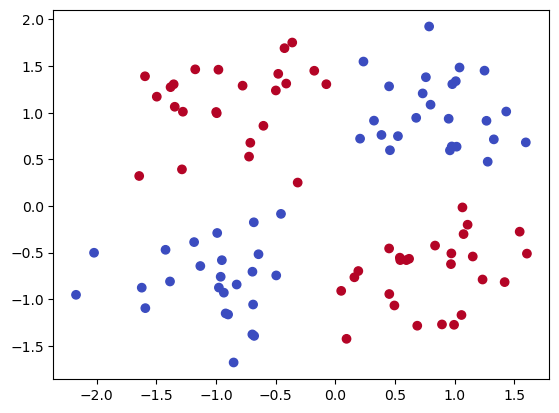

In [185]:
logdir = "logs"
now = datetime.now()
date_time = now.strftime("%Y%m%d_%H-%M-%S")
writer = SummaryWriter(logdir+"/"+date_time, flush_secs=1)


# Starting learning and testing
mlp.reset()
valid_split = 0.2; test_split = 0.1; batch_size = 32
learn(mlp, X, Y, valid_split, test_split, writer, 1)